**Este notebook irá fazer uma análise exploratória dos dados, preparar os dados e produzir um modelo para prever o Daily Active Users de aplicativos**

**estratégia:** será utilizado algoritmos mais robustos a outliers para uma produção mais rápida. Uma prática de melhoria seria um teste A/B aplicando a remoção/tratamento dos outliers, bem como, a utilização de selecionadores de melhores `features` como o `Boruta`

A base de  dados irá ser subdivida numa proporção 75% para o treinamento, 25% para validação. Essa subdivisão será feita a partir da data, uma vez que, esses dados estão ordenados por data.

No próximo passo, ao extrair dados do mySQL, será extraido esses mesmos dados para validação do modelo.

## prompts




> prompt 2: now please continue the data processing, justify the decisions and make a machine learning model, use at least 3 algorythms to test performance, my target is dauReal, adjust hyperparameters, use metrics and graphics to evaluate, maybe cross validation , save the model on drive at /content/drive/MyDrive/Codes/Rankmyapp/



> prompt 3: me dê um código apenas para identificar os outliers baseado no 1.5IQT



> prompt 4: quantile_transformer realmente ajuda com outliers?







# Bibliotecas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#libs de ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#libs para salvar
import pickle

#mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# funções

In [2]:
#identifica e reporta os outliers
def identificar_outliers_iqr(df, coluna):
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    outliers = df[(df[coluna] < limite_inferior) | (df[coluna] > limite_superior)]
    return outliers

# extração da base de dados

In [3]:
path = '/content/drive/MyDrive/Codes/Rankmyapp/data.csv'
df = pd.read_csv(path)
df

,appId,date,dauReal,predictionLoss,newinstalls,category,ratings,daily_ratings,reviews,daily_reviews
0,com.app.17806,2024-01-01,163431.0,27040.0,5955.0,OTHERS,682224.0,154.0,168471.0,57.0
1,com.app.80610,2024-01-01,611934.0,112183.0,10890.0,BUSINESS,893104.0,191.0,359446.0,120.0
2,com.app.62062,2024-01-01,22618.0,4554.0,871.0,SHOPPING,52665.0,1.0,1845.0,2.0
3,com.app.34216,2024-01-01,1729.0,1786.0,0.0,DESCONHECIDO,0.0,0.0,0.0,0.0
4,com.app.26790,2024-01-01,6245.0,1758.0,679.0,FINANCE,50415.0,0.0,26728.0,1.0
...,...,...,...,...,...,...,...,...,...,...
40846,com.app.37148,2024-10-01,11618.0,1174.0,149.0,DESCONHECIDO,0.0,0.0,0.0,0.0
40847,com.app.50679,2024-10-01,9683.0,1396.0,382.0,DESCONHECIDO,0.0,0.0,0.0,0.0
40848,com.app.35851,2024-10-01,6419.0,6301.0,270.0,DESCONHECIDO,0.0,0.0,0.0,0.0
40849,com.app.17441,2024-10-01,31452.0,3630.0,836.0,DESCONHECIDO,0.0,0.0,0.0,0.0


numa proporção 75% para o treinamento do modelo, 75% de 40851 linhas, são aproximadamente 30638. Vamos analisar a data correspondente conforme a estratégia:

In [5]:
df[30638:30639]

,appId,date,dauReal,predictionLoss,newinstalls,category,ratings,daily_ratings,reviews,daily_reviews
30638,com.app.21603,2024-07-24,74881.0,5132.0,2487.0,FINANCE,76285.0,64.0,20393.0,4.0


repare que a data é 24 de julho, logo deixaremos os dados a partir de 25 de julho para validação. E utilizaremos o de treino para esse notebook

In [4]:
train = df[df['date'] < '2024-07-25']
val = df[df['date'] >= '2024-07-25'].reset_index(drop=True)

# AED

## descritiva

In [ ]:
#análise descritiva geral
print(train.info())
print(train.nunique())
train.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 30784 entries, 0 to 30783
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   appId           30784 non-null  object 
 1   date            30784 non-null  object 
 2   dauReal         30784 non-null  float64
 3   predictionLoss  30784 non-null  float64
 4   newinstalls     30784 non-null  float64
 5   category        30784 non-null  object 
 6   ratings         30784 non-null  float64
 7   daily_ratings   30784 non-null  float64
 8   reviews         30784 non-null  float64
 9   daily_reviews   30784 non-null  float64
dtypes: float64(7), object(3)
memory usage: 2.6+ MB
None
appId               191
date                206
dauReal           24996
predictionLoss    13827
newinstalls        8740
category              7
ratings           23176
daily_ratings      1748
reviews           18950
daily_reviews       471
dtype: int64


,dauReal,predictionLoss,newinstalls,ratings,daily_ratings,reviews,daily_reviews
count,3.078400e+04,30784.000000,30784.000000,3.078400e+04,30784.000000,3.078400e+04,30784.000000
mean,4.352493e+05,12651.977228,3844.129028,2.920498e+05,135.148421,8.740054e+04,19.437305
std,1.326014e+06,24495.286532,8250.045486,7.598039e+05,363.303874,2.141516e+05,51.528832
min,7.500000e+02,0.000000,0.000000,0.000000e+00,-86.000000,0.000000e+00,-75.000000
25%,8.511000e+03,1777.000000,229.000000,7.874750e+03,1.000000,1.977000e+03,0.000000
50%,3.135550e+04,3903.000000,862.500000,4.462700e+04,12.000000,1.480500e+04,3.000000
75%,1.554758e+05,9475.500000,2908.000000,2.015360e+05,72.000000,4.970700e+04,12.000000
max,1.064815e+07,189683.000000,71825.000000,1.321433e+07,5297.000000,1.484672e+06,1808.000000


## histogramas

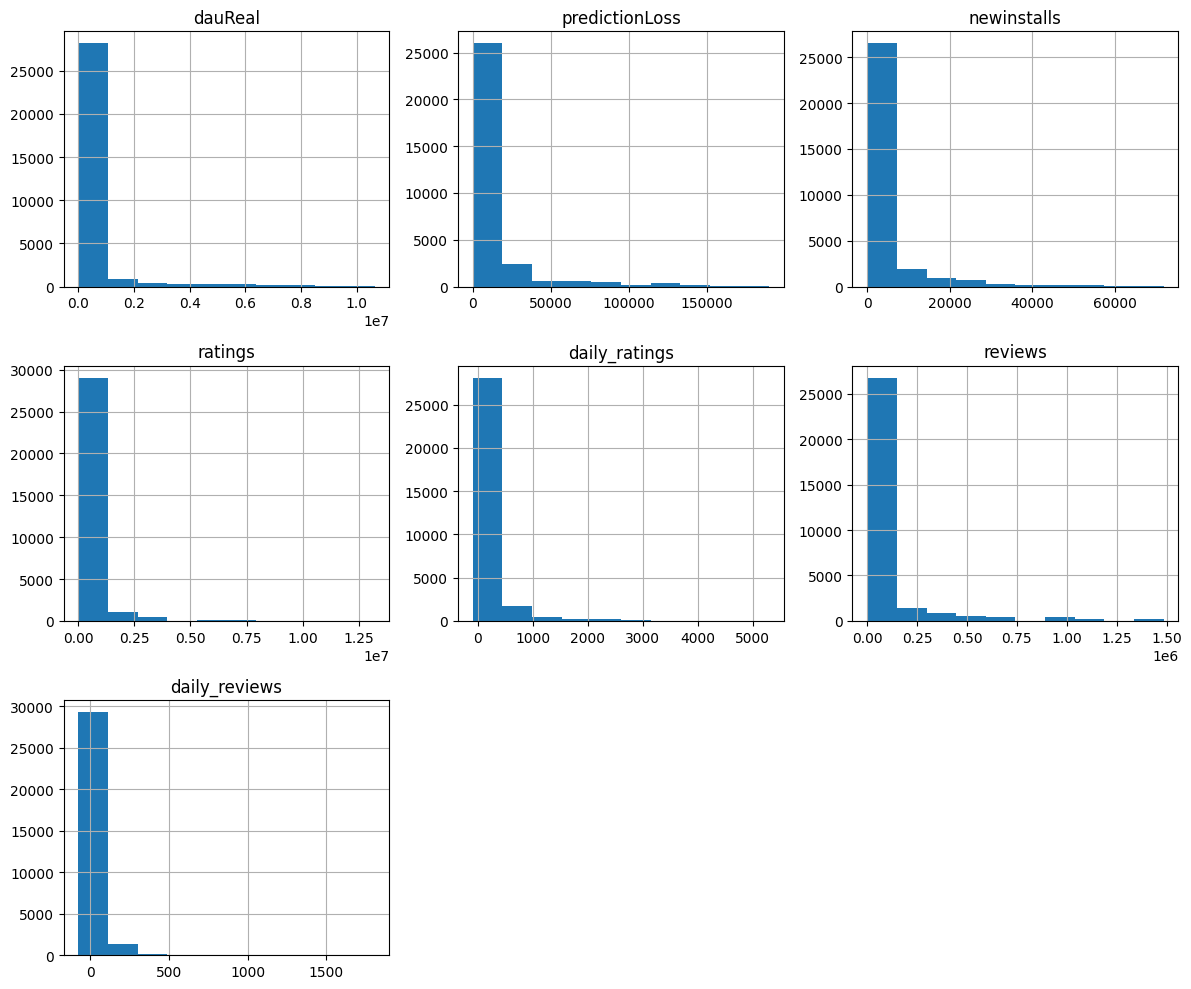

In [ ]:
#definindo numéricas
numerical_cols = train.select_dtypes(include=['float64', 'int64']).columns

# Histogramas
train[numerical_cols].hist(figsize=(12, 10))
plt.tight_layout()
plt.show()

conseguimos observar o quando assimétrico estão todas as distribuições e maior o corrência próximo a zero

## boxplots

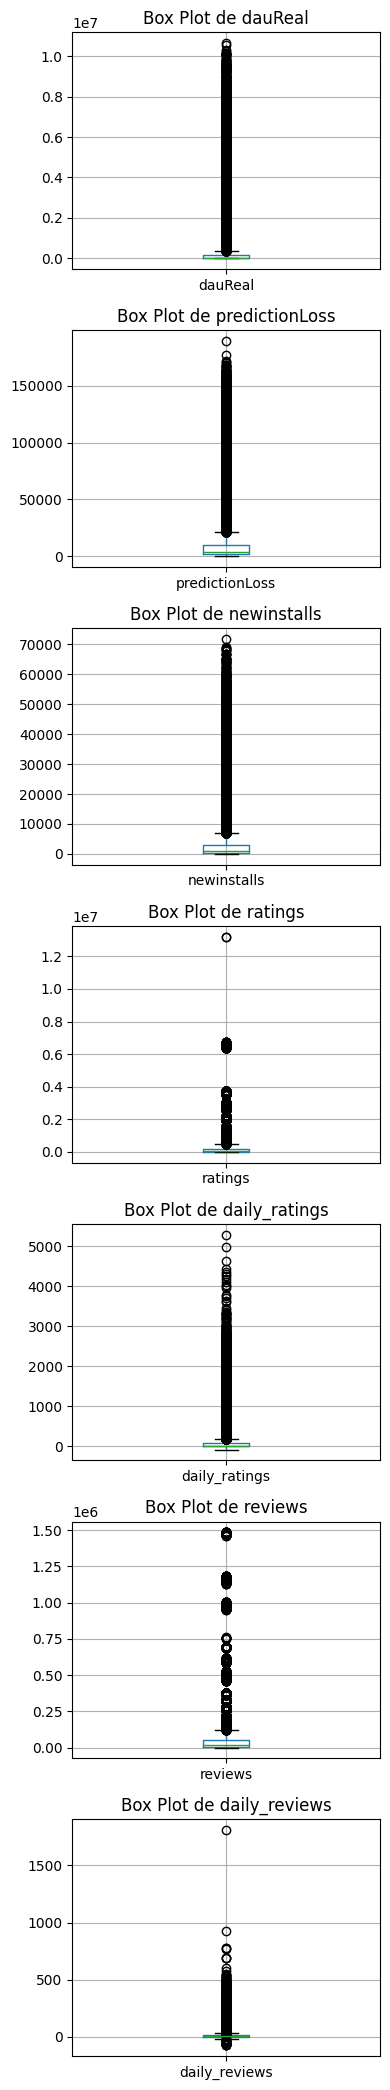

In [ ]:
fig, axes = plt.subplots(nrows=len(numerical_cols), ncols=1, figsize=(4, 3 * len(numerical_cols)))
for i, col in enumerate(numerical_cols):
    train.boxplot(column=col, ax=axes[i])
    axes[i].set_title(f'Box Plot de {col}')
plt.tight_layout()
plt.show()

com os boxplots, confirmamos a existência de outliers. Vamos identificá-los

## identificando outliers

In [ ]:
#outliers DAU
outliers_dau = identificar_outliers_iqr(train, 'dauReal')
outliers_dau

,appId,date,dauReal,predictionLoss,newinstalls,category,ratings,daily_ratings,reviews,daily_reviews
1,com.app.80610,2024-01-01,611934.0,112183.0,10890.0,BUSINESS,893104.0,191.0,359446.0,120.0
7,com.app.99432,2024-01-01,791535.0,15147.0,8039.0,BUSINESS,245095.0,6.0,138531.0,17.0
8,com.app.23305,2024-01-01,4686374.0,147684.0,37009.0,OTHERS,2544917.0,392.0,1131299.0,210.0
10,com.app.14509,2024-01-01,777969.0,37538.0,24465.0,FINANCE,1242231.0,149.0,584161.0,136.0
18,com.app.30329,2024-01-01,797005.0,79693.0,24915.0,FOOD_AND_DRINK,1391576.0,909.0,170012.0,65.0
...,...,...,...,...,...,...,...,...,...,...
30771,com.app.99432,2024-07-24,1193906.0,13200.0,10564.0,BUSINESS,257807.0,90.0,145670.0,34.0
30773,com.app.30329,2024-07-24,984665.0,80685.0,19500.0,FOOD_AND_DRINK,1593928.0,40.0,202303.0,17.0
30774,com.app.14509,2024-07-24,1362122.0,40163.0,16348.0,FINANCE,1386204.0,941.0,610198.0,120.0
30780,com.app.23305,2024-07-24,5367353.0,129708.0,33258.0,OTHERS,2660892.0,643.0,1183136.0,265.0


In [ ]:
#outliers predictionLoss
outliers_predictionLoss = identificar_outliers_iqr(train, 'predictionLoss')
outliers_predictionLoss

,appId,date,dauReal,predictionLoss,newinstalls,category,ratings,daily_ratings,reviews,daily_reviews
0,com.app.17806,2024-01-01,163431.0,27040.0,5955.0,OTHERS,682224.0,154.0,168471.0,57.0
1,com.app.80610,2024-01-01,611934.0,112183.0,10890.0,BUSINESS,893104.0,191.0,359446.0,120.0
8,com.app.23305,2024-01-01,4686374.0,147684.0,37009.0,OTHERS,2544917.0,392.0,1131299.0,210.0
10,com.app.14509,2024-01-01,777969.0,37538.0,24465.0,FINANCE,1242231.0,149.0,584161.0,136.0
18,com.app.30329,2024-01-01,797005.0,79693.0,24915.0,FOOD_AND_DRINK,1391576.0,909.0,170012.0,65.0
...,...,...,...,...,...,...,...,...,...,...
30765,com.app.80610,2024-07-24,883907.0,109809.0,10078.0,BUSINESS,975899.0,3089.0,379360.0,136.0
30773,com.app.30329,2024-07-24,984665.0,80685.0,19500.0,FOOD_AND_DRINK,1593928.0,40.0,202303.0,17.0
30774,com.app.14509,2024-07-24,1362122.0,40163.0,16348.0,FINANCE,1386204.0,941.0,610198.0,120.0
30780,com.app.23305,2024-07-24,5367353.0,129708.0,33258.0,OTHERS,2660892.0,643.0,1183136.0,265.0


In [ ]:
#outliers newinstalls
outliers_newinstalls = identificar_outliers_iqr(train, 'newinstalls')
outliers_newinstalls

,appId,date,dauReal,predictionLoss,newinstalls,category,ratings,daily_ratings,reviews,daily_reviews
1,com.app.80610,2024-01-01,611934.0,112183.0,10890.0,BUSINESS,893104.0,191.0,359446.0,120.0
7,com.app.99432,2024-01-01,791535.0,15147.0,8039.0,BUSINESS,245095.0,6.0,138531.0,17.0
8,com.app.23305,2024-01-01,4686374.0,147684.0,37009.0,OTHERS,2544917.0,392.0,1131299.0,210.0
10,com.app.14509,2024-01-01,777969.0,37538.0,24465.0,FINANCE,1242231.0,149.0,584161.0,136.0
18,com.app.30329,2024-01-01,797005.0,79693.0,24915.0,FOOD_AND_DRINK,1391576.0,909.0,170012.0,65.0
...,...,...,...,...,...,...,...,...,...,...
30771,com.app.99432,2024-07-24,1193906.0,13200.0,10564.0,BUSINESS,257807.0,90.0,145670.0,34.0
30773,com.app.30329,2024-07-24,984665.0,80685.0,19500.0,FOOD_AND_DRINK,1593928.0,40.0,202303.0,17.0
30774,com.app.14509,2024-07-24,1362122.0,40163.0,16348.0,FINANCE,1386204.0,941.0,610198.0,120.0
30780,com.app.23305,2024-07-24,5367353.0,129708.0,33258.0,OTHERS,2660892.0,643.0,1183136.0,265.0


In [ ]:
#outliers ratings
outliers_ratings = identificar_outliers_iqr(train, 'ratings')
outliers_ratings

,appId,date,dauReal,predictionLoss,newinstalls,category,ratings,daily_ratings,reviews,daily_reviews
0,com.app.17806,2024-01-01,163431.0,27040.0,5955.0,OTHERS,682224.0,154.0,168471.0,57.0
1,com.app.80610,2024-01-01,611934.0,112183.0,10890.0,BUSINESS,893104.0,191.0,359446.0,120.0
8,com.app.23305,2024-01-01,4686374.0,147684.0,37009.0,OTHERS,2544917.0,392.0,1131299.0,210.0
10,com.app.14509,2024-01-01,777969.0,37538.0,24465.0,FINANCE,1242231.0,149.0,584161.0,136.0
18,com.app.30329,2024-01-01,797005.0,79693.0,24915.0,FOOD_AND_DRINK,1391576.0,909.0,170012.0,65.0
...,...,...,...,...,...,...,...,...,...,...
30765,com.app.80610,2024-07-24,883907.0,109809.0,10078.0,BUSINESS,975899.0,3089.0,379360.0,136.0
30773,com.app.30329,2024-07-24,984665.0,80685.0,19500.0,FOOD_AND_DRINK,1593928.0,40.0,202303.0,17.0
30774,com.app.14509,2024-07-24,1362122.0,40163.0,16348.0,FINANCE,1386204.0,941.0,610198.0,120.0
30780,com.app.23305,2024-07-24,5367353.0,129708.0,33258.0,OTHERS,2660892.0,643.0,1183136.0,265.0


In [ ]:
#outliers daily_ratings
outliers_daily_ratings = identificar_outliers_iqr(train, 'daily_ratings')
outliers_daily_ratings

,appId,date,dauReal,predictionLoss,newinstalls,category,ratings,daily_ratings,reviews,daily_reviews
1,com.app.80610,2024-01-01,611934.0,112183.0,10890.0,BUSINESS,893104.0,191.0,359446.0,120.0
8,com.app.23305,2024-01-01,4686374.0,147684.0,37009.0,OTHERS,2544917.0,392.0,1131299.0,210.0
18,com.app.30329,2024-01-01,797005.0,79693.0,24915.0,FOOD_AND_DRINK,1391576.0,909.0,170012.0,65.0
26,com.app.15675,2024-01-01,83565.0,2503.0,3490.0,FINANCE,546582.0,220.0,83173.0,204.0
29,com.app.88509,2024-01-01,4094009.0,27530.0,53137.0,OTHERS,961533.0,365.0,496734.0,157.0
...,...,...,...,...,...,...,...,...,...,...
30764,com.app.17806,2024-07-24,350367.0,30724.0,9456.0,OTHERS,763867.0,391.0,177429.0,42.0
30765,com.app.80610,2024-07-24,883907.0,109809.0,10078.0,BUSINESS,975899.0,3089.0,379360.0,136.0
30774,com.app.14509,2024-07-24,1362122.0,40163.0,16348.0,FINANCE,1386204.0,941.0,610198.0,120.0
30780,com.app.23305,2024-07-24,5367353.0,129708.0,33258.0,OTHERS,2660892.0,643.0,1183136.0,265.0


In [ ]:
#outliers reviews
outliers_reviews = identificar_outliers_iqr(train, 'reviews')
outliers_reviews

,appId,date,dauReal,predictionLoss,newinstalls,category,ratings,daily_ratings,reviews,daily_reviews
0,com.app.17806,2024-01-01,163431.0,27040.0,5955.0,OTHERS,682224.0,154.0,168471.0,57.0
1,com.app.80610,2024-01-01,611934.0,112183.0,10890.0,BUSINESS,893104.0,191.0,359446.0,120.0
7,com.app.99432,2024-01-01,791535.0,15147.0,8039.0,BUSINESS,245095.0,6.0,138531.0,17.0
8,com.app.23305,2024-01-01,4686374.0,147684.0,37009.0,OTHERS,2544917.0,392.0,1131299.0,210.0
10,com.app.14509,2024-01-01,777969.0,37538.0,24465.0,FINANCE,1242231.0,149.0,584161.0,136.0
...,...,...,...,...,...,...,...,...,...,...
30771,com.app.99432,2024-07-24,1193906.0,13200.0,10564.0,BUSINESS,257807.0,90.0,145670.0,34.0
30773,com.app.30329,2024-07-24,984665.0,80685.0,19500.0,FOOD_AND_DRINK,1593928.0,40.0,202303.0,17.0
30774,com.app.14509,2024-07-24,1362122.0,40163.0,16348.0,FINANCE,1386204.0,941.0,610198.0,120.0
30780,com.app.23305,2024-07-24,5367353.0,129708.0,33258.0,OTHERS,2660892.0,643.0,1183136.0,265.0


In [ ]:
#outliers daily_reviews
outliers_daily_reviews = identificar_outliers_iqr(train, 'daily_reviews')
outliers_daily_reviews

,appId,date,dauReal,predictionLoss,newinstalls,category,ratings,daily_ratings,reviews,daily_reviews
0,com.app.17806,2024-01-01,163431.0,27040.0,5955.0,OTHERS,682224.0,154.0,168471.0,57.0
1,com.app.80610,2024-01-01,611934.0,112183.0,10890.0,BUSINESS,893104.0,191.0,359446.0,120.0
8,com.app.23305,2024-01-01,4686374.0,147684.0,37009.0,OTHERS,2544917.0,392.0,1131299.0,210.0
10,com.app.14509,2024-01-01,777969.0,37538.0,24465.0,FINANCE,1242231.0,149.0,584161.0,136.0
18,com.app.30329,2024-01-01,797005.0,79693.0,24915.0,FOOD_AND_DRINK,1391576.0,909.0,170012.0,65.0
...,...,...,...,...,...,...,...,...,...,...
30765,com.app.80610,2024-07-24,883907.0,109809.0,10078.0,BUSINESS,975899.0,3089.0,379360.0,136.0
30771,com.app.99432,2024-07-24,1193906.0,13200.0,10564.0,BUSINESS,257807.0,90.0,145670.0,34.0
30774,com.app.14509,2024-07-24,1362122.0,40163.0,16348.0,FINANCE,1386204.0,941.0,610198.0,120.0
30780,com.app.23305,2024-07-24,5367353.0,129708.0,33258.0,OTHERS,2660892.0,643.0,1183136.0,265.0


É possível observar reincidência de quais linhas são outliers, isso sugere de que esses dados se tratam de medições legitimas, em que ouveram pico dee certos aplicativos, e tais variaveis influenciam

## categórica

com apenas uma variável categórica, vamos observar a proporção dos valores

In [ ]:
train['category'].value_counts()

,count
category,
FINANCE,11639
OTHERS,6996
SHOPPING,5192
BUSINESS,2658
TRAVEL_AND_LOCAL,1866
DESCONHECIDO,1535
FOOD_AND_DRINK,898


## correlação

aqui podemos identificar variáveis que são altamente correlacionadas e removê-las, uma vez que agregam a mesma informação, selecionando para ficar aquela que têm maior correlação com a target

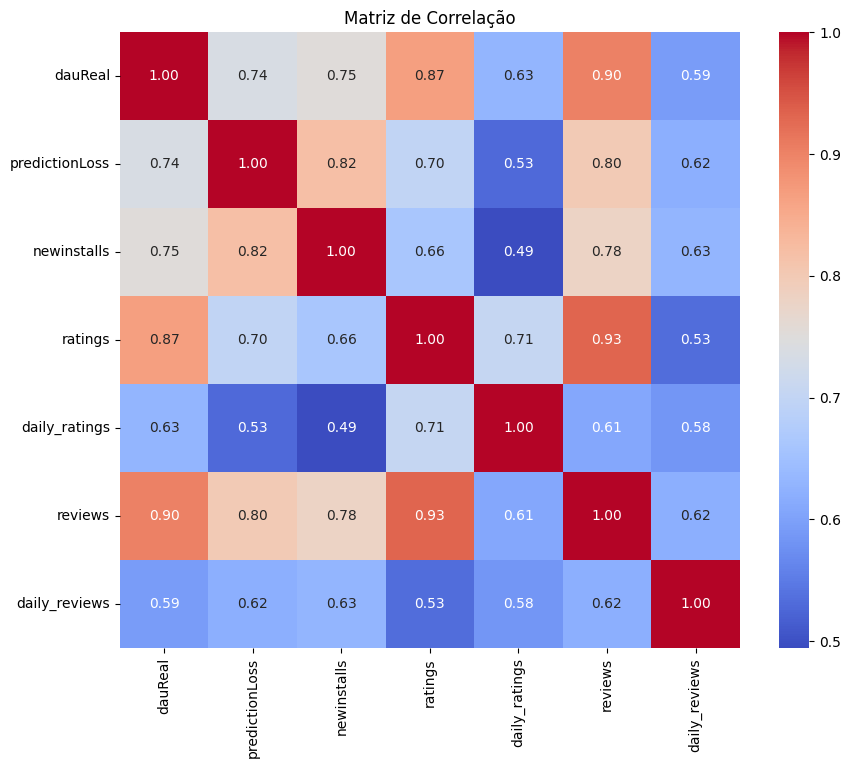

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(train[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação')
plt.show()

como há alta correlação entre reviews e ratings, podemos manter reviews e retirar ratings e predictionLoss. Porém vamos manter newintalls. Que altamente correlacionado com ela. Isso ajuda a evitar multicolinearidade em algoritmos lineares, mesmo que ensembles lidem bem com isso

[fonte: medium](https://medium.com/data-hackers/como-selecionar-as-melhores-features-para-seu-modelo-de-machine-learning-faf74e357913)

# Preparação do modelo

como todos os dados estão em 2024, não iremos adotar a data para fatores sazonais. Retiraremos as antes discutidas e também, e os IDs para não atrapalhar o modelo

- removeremos os `ids` pois pode gerar overfitting
- ao aplicar onehotencoding, geraria muitas features
- como há categorias, já há agrupamento para segmentar

## encoding

**encoders:** `StandarScaler` irá normalizar as numéricas e o `onehotencoder` irá numerar a categórica

In [6]:
#remover colunas
X = train.drop(['appId', 'date', 'dauReal', 'predictionLoss', 'ratings'], axis=1)
y = train['dauReal']

#separando numéricas e categóricas
categorical_features = ['category']
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

#encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

#apllicando em X
X_processed = preprocessor.fit_transform(X)

#verificando shape dos dados processados
X_processed.shape

(30784, 11)

In [ ]:
X_processed

array([[ 0.25586589,  0.05189013,  0.37857189, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.85405413,  0.1537349 ,  1.27036117, ...,  0.        ,
         0.        ,  0.        ],
       [-0.36038314, -0.36925177, -0.39951571, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 2.60813355,  4.29083478,  6.52478969, ...,  0.        ,
         0.        ,  0.        ],
       [-0.42911115, -0.27566469, -0.36247126, ...,  0.        ,
         0.        ,  0.        ],
       [-0.05431925, -0.21510833, -0.31507416, ...,  0.        ,
         0.        ,  0.        ]])

## split

para avaliação deste notebook iremos utilizar a proporção 80/20

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

#shapes
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (24627, 11)
X_test: (6157, 11)
y_train: (24627,)
y_test: (6157,)


## Algoritmos

**RMSE** (Raiz do erro padrão médio) irá avaliar os modelos para a seleção dos algoritmos. Ela uma das melhores métricas por penalizar grande erros. Quanto menor, melhor

Uma técnica de avaliação para ter uma melhor média dessa métrica é a cross-validation ou validação cruzada

### Regressão Linear

utilizaremos regressão linear como um modelode base ao comparar outros algoritmos mais robustos e menos sensíveis a outliers

In [ ]:
#treino
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

#avaliação com
scores = cross_val_score(linear_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
rmse_scores = (-scores)**0.5

print("Linear Regression Cross-Validation RMSE:", rmse_scores)
print("Linear Regression  Média da RMSE:", rmse_scores.mean())

Linear Regression Cross-Validation RMSE: [547966.66980589 492602.11515762 617906.47373617 530160.12846086
 492152.67471096]
Linear Regression  Média da RMSE: 536157.612374299


### Random forest

como ele é menos sensível a outlier, iremos utilizá-lo

In [8]:
#treino
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(X_train, y_train)

#avaliação
scores = cross_val_score(forest_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
rmse_scores = (-scores)**0.5

print("Random Forest Regressor Cross-Validation RMSE:", rmse_scores)
print("Random Forest Regressor Média de RMSE:", rmse_scores.mean())

Random Forest Regressor Cross-Validation RMSE: [232874.15219102 147809.77675822 244666.19975197 141654.5889016
 147899.61012246]
Random Forest Regressor Média de RMSE: 182980.8655450555


### Gradient Boosting

Um 3º algoritmo sendo ensemble, o Gradient Boosting corrige os erros das árvores anteriores, sendo menos propenso a overfitting

In [ ]:
#treino
gbrt = GradientBoostingRegressor(random_state=42)
gbrt.fit(X_train, y_train)

#avaliação
scores = cross_val_score(gbrt, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
rmse_scores = (-scores)**0.5

print("Gradient Boosting Regressor Cross-Validation RMSE:", rmse_scores)
print("Gradient Boosting Regressor Média de RMSE:", rmse_scores.mean())

Gradient Boosting Regressor Cross-Validation RMSE: [267161.8112208  190383.98053606 272853.19885725 220185.9680818
 215937.97953418]
Gradient Boosting Regressor Média de RMSE: 233304.58764601886


## Tunamento

Devido ao tempo de realização do case e o tempo de execução dos procedimentos de tunamento do modelo, decidi não agregar ao modelo, pois demorou muito para executar em minha máquina. Trago aqui um exemplo de como planejei aplicar `gridsearch` para encontrar os melhores hiperparâmetros para o modelo:


```
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Melhores parâmetros:", grid_search.best_params_)
print("Melhores Estimadores:", grid_search.best_estimator_)

```



*   `n_estimators: `número de árvores, quanto mais, melhor performance e mais custo
*   `max_depth:` para evitar overfitting e underfitting
*   `min_sample_split:` mínimo de nodes que irá se subdividir
*   `min_sample_leaf:` limite mínimo de folhas nas árvores (complexidade)
*   `bootstrap:` Usa ou não amostragem com reposição

[fonte: geek for geeks](https://www.geeksforgeeks.org/machine-learning/random-forest-hyperparameter-tuning-in-python/)





## Seleção e salvamento

como o Random Forest obteve o melhor desempenho iremos salvá-lo para a validação

In [ ]:
# Caminho para salvar o modelo no Drive
caminho_modelo = '/content/drive/MyDrive/Codes/Rankmyapp/modelo_previsao_dau.pkl'

# Salvando o modelo forest_reg em modo binário
with open(caminho_modelo, 'wb') as f:
    pickle.dump(forest_reg, f)